# Quick Start PyTorch - CIFAR10
To run a Code Cell you can click on the ⏯ Run button in the Navigation Bar above or type Shift + Enter

### Import libs and load dataset

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### Show images in dataset

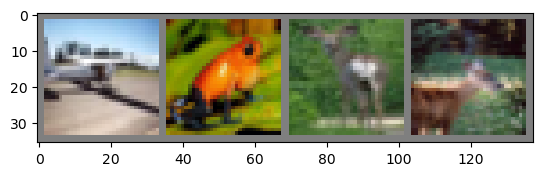

plane frog  deer  deer 


In [11]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Model 

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, (5, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = torchvision.models.vgg11().cuda()

loss_list = []

accuracy_list = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

[1,  2000] loss: 2.369
[1,  4000] loss: 1.822
[1,  6000] loss: 1.645
[1,  8000] loss: 1.535
[1, 10000] loss: 1.409
[1, 12000] loss: 1.357
[2,  2000] loss: 1.209
[2,  4000] loss: 1.160
[2,  6000] loss: 1.108
[2,  8000] loss: 1.098
[2, 10000] loss: 1.031
[2, 12000] loss: 1.021
Finished Training


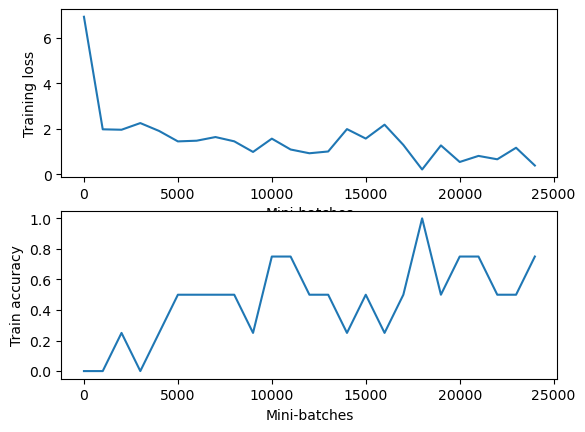

In [14]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        labels.to('cuda:0')
        # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct = 0
        total = 0
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct += 1
            total += 1

        accuracy = correct / total
        accuracy_list.append(accuracy)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

gap = 1000  # sampling gap
plt.subplot(2, 1, 1)
plt.plot(list(range(0, len(loss_list), gap)), loss_list[::gap])
plt.xlabel('Mini-batches')
plt.ylabel('Training loss')
plt.subplot(2, 1, 2)
plt.plot(list(range(0, len(accuracy_list), gap)), accuracy_list[::gap])
plt.xlabel('Mini-batches')
plt.ylabel('Train accuracy')
plt.show()


### Testing

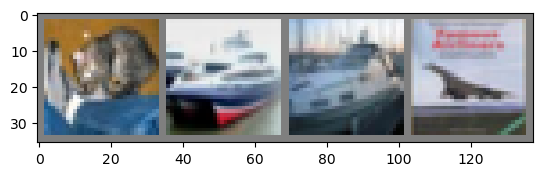

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   car   plane plane
Accuracy of the network on the 10000 test images: 62 %


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.cuda())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


### Calculate accuracy for each class

In [9]:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')



Accuracy for class: plane is 76.1 %
Accuracy for class: car   is 76.5 %
Accuracy for class: bird  is 62.4 %
Accuracy for class: cat   is 46.9 %
Accuracy for class: deer  is 65.3 %
Accuracy for class: dog   is 21.8 %
Accuracy for class: frog  is 77.5 %
Accuracy for class: horse is 71.2 %
Accuracy for class: ship  is 85.8 %
Accuracy for class: truck is 74.8 %
